Importing all libraries that will be used during this analysis. Since we will run some trend and graphic analysis, all libraries bellow should be used. 

Note on the dataset - the data is the same for the 210 entries, meaning that we have only one valid month (30 days), the rest of them are only duplicates. 

In [179]:
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import norm
import statistics

from mlxtend.preprocessing import minmax_scaling

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, date, time
np.random.seed(0)

In [180]:
nyc_filepath = "../raw_data/nyc-east-river-bicycle-counts.csv"

In [181]:
nyc_cycle_data = pd.read_csv(nyc_filepath)

In [182]:
nyc_cycle_data.head()

,Unnamed: 0,Date,Day,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total
0,0,2016-04-01 00:00:00,2016-04-01 00:00:00,78.1,66.0,0.01,1704.0,3126,4115.0,2552.0,11497
1,1,2016-04-02 00:00:00,2016-04-02 00:00:00,55.0,48.9,0.15,827.0,1646,2565.0,1884.0,6922
2,2,2016-04-03 00:00:00,2016-04-03 00:00:00,39.9,34.0,0.09,526.0,1232,1695.0,1306.0,4759
3,3,2016-04-04 00:00:00,2016-04-04 00:00:00,44.1,33.1,0.47 (S),521.0,1067,1440.0,1307.0,4335
4,4,2016-04-05 00:00:00,2016-04-05 00:00:00,42.1,26.1,0,1416.0,2617,3081.0,2357.0,9471


Checking current data shape to understand what are the necessary analysis that can be run.

In [183]:
print(nyc_cycle_data.shape)
print(nyc_cycle_data.info)

(210, 11)
<bound method DataFrame.info of      Unnamed: 0                 Date                  Day  High Temp (°F)   
0             0  2016-04-01 00:00:00  2016-04-01 00:00:00            78.1  \
1             1  2016-04-02 00:00:00  2016-04-02 00:00:00            55.0   
2             2  2016-04-03 00:00:00  2016-04-03 00:00:00            39.9   
3             3  2016-04-04 00:00:00  2016-04-04 00:00:00            44.1   
4             4  2016-04-05 00:00:00  2016-04-05 00:00:00            42.1   
..          ...                  ...                  ...             ...   
205         205  2016-04-26 00:00:00  2016-04-26 00:00:00            60.1   
206         206  2016-04-27 00:00:00  2016-04-27 00:00:00            62.1   
207         207  2016-04-28 00:00:00  2016-04-28 00:00:00            57.9   
208         208  2016-04-29 00:00:00  2016-04-29 00:00:00            57.0   
209         209  2016-04-30 00:00:00  2016-04-30 00:00:00            64.0   

     Low Temp (°F) Precipitation 

In [184]:
new_nyc_data = nyc_cycle_data.drop_duplicates(subset=['Date'])

Decided to create a 'mean temperature' using low and high temperature. It's not the best apporach, but might give some interesting insights over how temprature affects the quantity of cyclists.

In [185]:
new_nyc_data["mean temperature"] = (new_nyc_data['Low Temp (°F)'] + new_nyc_data['High Temp (°F)'])/2

/tmp/ipykernel_6424/463364123.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_nyc_data["mean temperature"] = (new_nyc_data['Low Temp (°F)'] + new_nyc_data['High Temp (°F)'])/2


In [186]:
new_nyc_data.tail()

,Unnamed: 0,Date,Day,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total,mean temperature
25,25,2016-04-26 00:00:00,2016-04-26 00:00:00,60.1,46.9,0.24,1997.0,3520,4559.0,2929.0,13005,53.50
26,26,2016-04-27 00:00:00,2016-04-27 00:00:00,62.1,46.9,0,3343.0,5606,6577.0,4388.0,19914,54.50
27,27,2016-04-28 00:00:00,2016-04-28 00:00:00,57.9,48.0,0,2486.0,4152,5336.0,3657.0,15631,52.95
28,28,2016-04-29 00:00:00,2016-04-29 00:00:00,57.0,46.9,0.05,2375.0,4178,5053.0,3348.0,14954,51.95
29,29,2016-04-30 00:00:00,2016-04-30 00:00:00,64.0,48.0,0,3199.0,4952,5675.0,3606.0,17432,56.00


Noted that on precipitation column had a mixed type (int and str), did some transformations to separate the data without loosing any information. Note that (S) means Snow, and T was traces of rain, which in this case I decided to substitute for 0

In [187]:
print(new_nyc_data['Precipitation'])
precipitation_data = new_nyc_data['Precipitation'].str.split(" ", n=1, expand=True)
new_nyc_data["Precipitation"] = precipitation_data[0]
new_nyc_data["Weather State"] = precipitation_data [1]

0         0.01
1         0.15
2         0.09
3     0.47 (S)
4            0
5            0
6         0.09
7         0.01
8         0.09
9            0
10        0.01
11         0.2
12           0
13           0
14           0
15           0
16           0
17           0
18           0
19           0
20           0
21           T
22        0.16
23           0
24           0
25        0.24
26           0
27           0
28        0.05
29           0
Name: Precipitation, dtype: object


/tmp/ipykernel_6424/4098572141.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_nyc_data["Precipitation"] = precipitation_data[0]
/tmp/ipykernel_6424/4098572141.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_nyc_data["Weather State"] = precipitation_data [1]


In [188]:
new_nyc_data.tail()

,Unnamed: 0,Date,Day,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total,mean temperature,Weather State
25,25,2016-04-26 00:00:00,2016-04-26 00:00:00,60.1,46.9,0.24,1997.0,3520,4559.0,2929.0,13005,53.50,None
26,26,2016-04-27 00:00:00,2016-04-27 00:00:00,62.1,46.9,0,3343.0,5606,6577.0,4388.0,19914,54.50,None
27,27,2016-04-28 00:00:00,2016-04-28 00:00:00,57.9,48.0,0,2486.0,4152,5336.0,3657.0,15631,52.95,None
28,28,2016-04-29 00:00:00,2016-04-29 00:00:00,57.0,46.9,0.05,2375.0,4178,5053.0,3348.0,14954,51.95,None
29,29,2016-04-30 00:00:00,2016-04-30 00:00:00,64.0,48.0,0,3199.0,4952,5675.0,3606.0,17432,56.00,None


In [189]:
new_nyc_data['Precipitation'] = new_nyc_data['Precipitation'].str.replace("T", "0.01")

/tmp/ipykernel_6424/3238537556.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_nyc_data['Precipitation'] = new_nyc_data['Precipitation'].str.replace("T", "0.01")


In [190]:
new_nyc_data['Precipitation']

0     0.01
1     0.15
2     0.09
3     0.47
4        0
5        0
6     0.09
7     0.01
8     0.09
9        0
10    0.01
11     0.2
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21    0.01
22    0.16
23       0
24       0
25    0.24
26       0
27       0
28    0.05
29       0
Name: Precipitation, dtype: object

Scaled the precipitation data using minmax_scaling, so everything would fall in a 0 - 1 range, facilitating the analysis. 

In [191]:
original_data = pd.DataFrame(new_nyc_data['Precipitation'])

scaled_data = minmax_scaling(original_data, columns=['Precipitation'])

In [192]:
scaled_data

,Precipitation
0,0.021277
1,0.319149
2,0.191489
3,1.000000
4,0.000000
5,0.000000
6,0.191489
7,0.021277
8,0.191489
9,0.000000


Adjusting the column 'Date' in order to get only the full date and not effective time since they are all 00:00:00 so can be dismissed. 

In [193]:
new_nyc_data['Date'] = pd.to_datetime(new_nyc_data['Date']).dt.date
new_nyc_data['Day'] = pd.to_datetime(new_nyc_data['Date']).dt.day

/tmp/ipykernel_6424/4117213573.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_nyc_data['Date'] = pd.to_datetime(new_nyc_data['Date']).dt.date
/tmp/ipykernel_6424/4117213573.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_nyc_data['Day'] = pd.to_datetime(new_nyc_data['Date']).dt.day


In [194]:
new_nyc_data['Day']

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
19    20
20    21
21    22
22    23
23    24
24    25
25    26
26    27
27    28
28    29
29    30
Name: Day, dtype: int32

Plotting the total of cyclists per day using a barplot. 

<Axes: title={'center': 'Total Number of cyclists per day'}, xlabel='Date', ylabel='Total'>

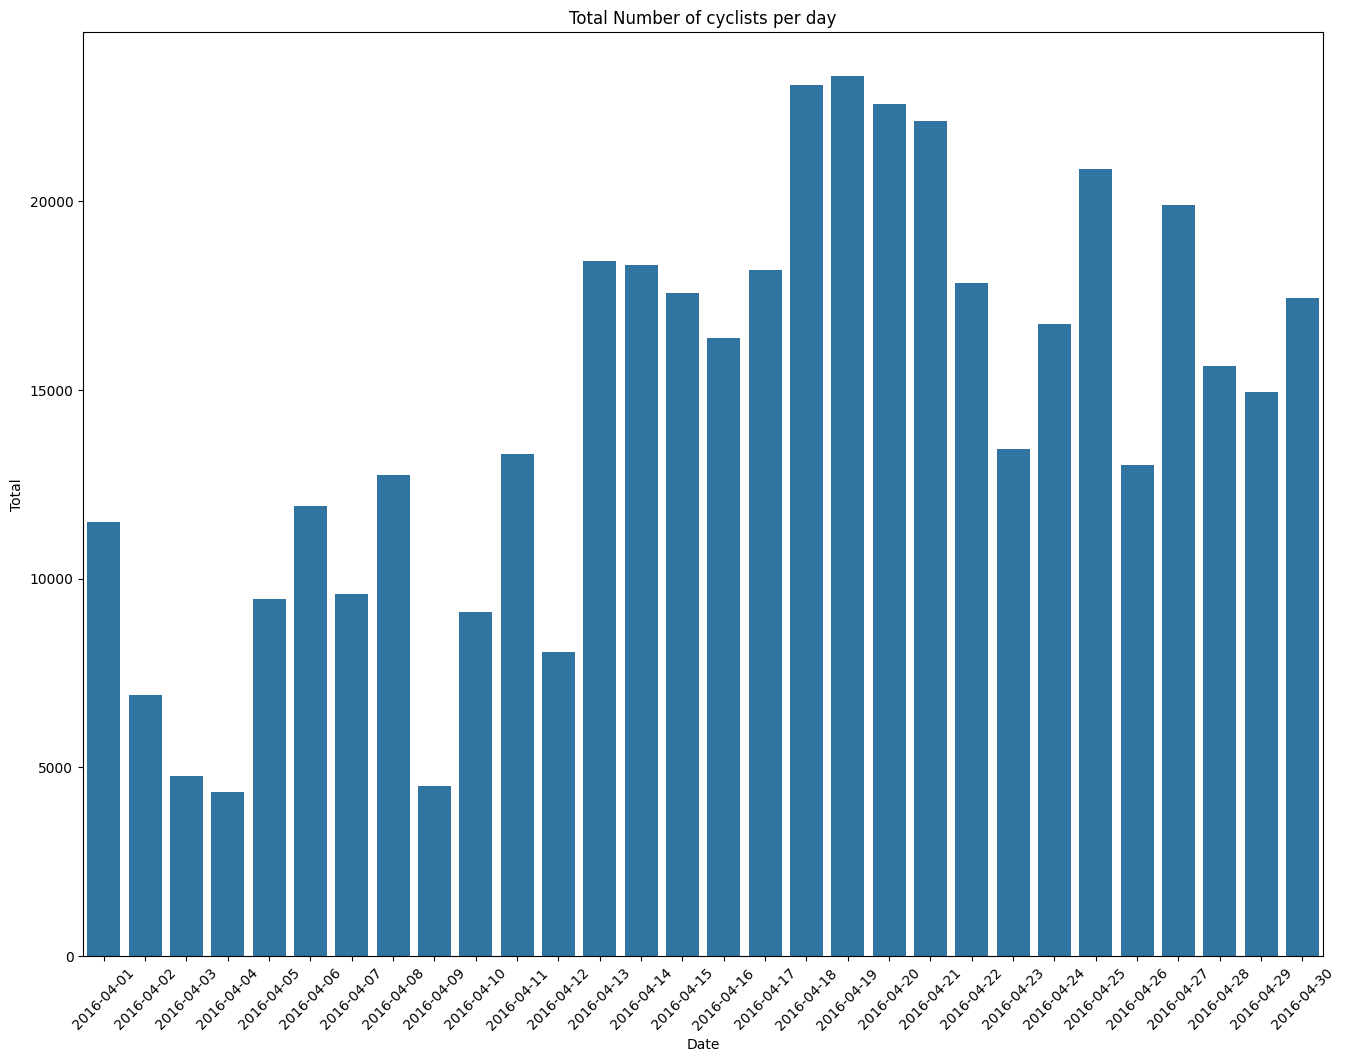

In [195]:
plt.figure(figsize=(16,12))
plt.title('Total Number of cyclists per day')
plt.xticks(rotation=45)
sns.barplot(x=new_nyc_data['Date'], y=new_nyc_data['Total'])


Using mean temperature and a scatterplot to understand the possible relation of higher tempratures to a higher number of cyclists, which can be infered later by the regression plot. 

Note that regression plot might not be the most suitable use for this.

<Axes: xlabel='mean temperature', ylabel='Total'>

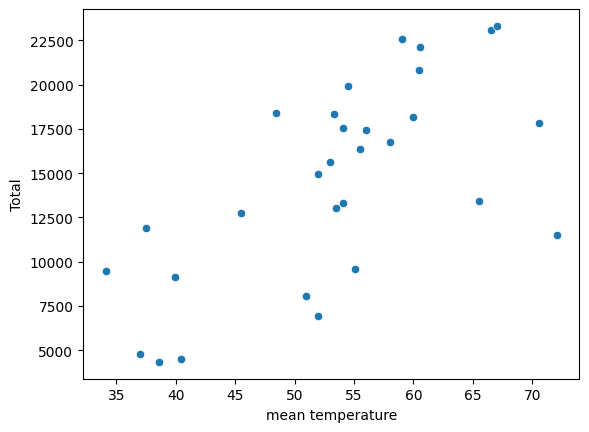

In [196]:
sns.scatterplot(x=new_nyc_data['mean temperature'], y=new_nyc_data['Total'])

<Axes: xlabel='mean temperature', ylabel='Total'>

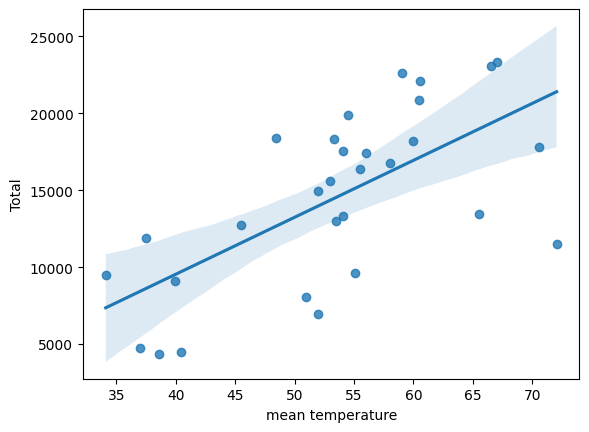

In [197]:
sns.regplot(x=new_nyc_data['mean temperature'], y=new_nyc_data['Total'])

In [198]:
new_nyc_data['Precipitation Normalized'] = scaled_data

/tmp/ipykernel_6424/2321674248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_nyc_data['Precipitation Normalized'] = scaled_data


In [199]:
new_nyc_data.head()

,Unnamed: 0,Date,Day,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total,mean temperature,Weather State,Precipitation Normalized
0,0,2016-04-01,1,78.1,66.0,0.01,1704.0,3126,4115.0,2552.0,11497,72.05,None,0.021277
1,1,2016-04-02,2,55.0,48.9,0.15,827.0,1646,2565.0,1884.0,6922,51.95,None,0.319149
2,2,2016-04-03,3,39.9,34.0,0.09,526.0,1232,1695.0,1306.0,4759,36.95,None,0.191489
3,3,2016-04-04,4,44.1,33.1,0.47,521.0,1067,1440.0,1307.0,4335,38.60,(S),1.000000
4,4,2016-04-05,5,42.1,26.1,0,1416.0,2617,3081.0,2357.0,9471,34.10,None,0.000000


Decided to use the scaled preicipitation to understand relation of number of cyclists with rain, also using a linear regression. 

<Axes: xlabel='Precipitation Normalized', ylabel='Total'>

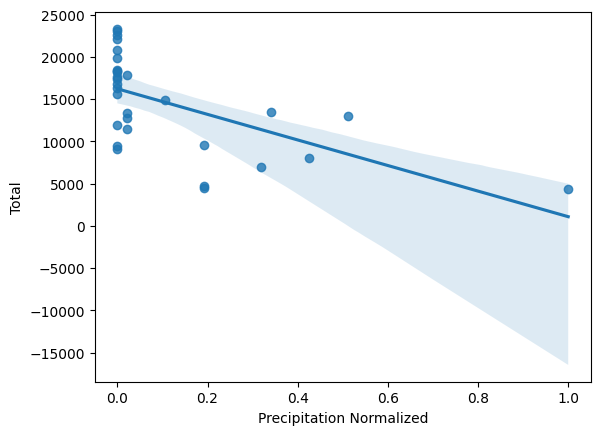

In [200]:
sns.regplot(x=new_nyc_data['Precipitation Normalized'], y=new_nyc_data['Total'])

<Axes: xlabel='Precipitation Normalized', ylabel='Total'>

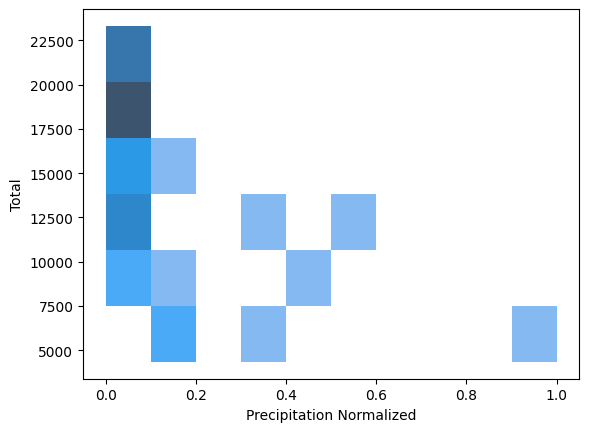

In [201]:
sns.histplot(x=new_nyc_data['Precipitation Normalized'], y=new_nyc_data['Total'])

using a joinplot to give a better visualisation of precipitation and total number of cyclists.

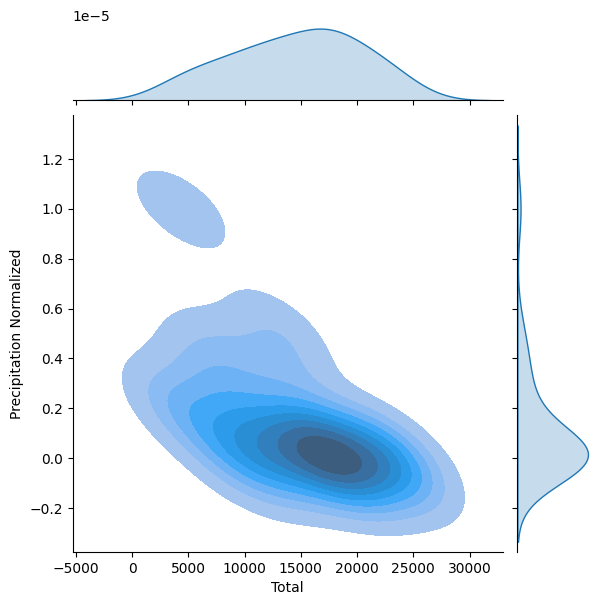

In [202]:
sns.jointplot(x=new_nyc_data['Total'], y=new_nyc_data['Precipitation Normalized'], kind="kde", fill=True)

In [203]:
test_df = nyc_cycle_data.drop_duplicates(subset=['Date'])

In [204]:
test_df.head()

,Unnamed: 0,Date,Day,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total
0,0,2016-04-01 00:00:00,2016-04-01 00:00:00,78.1,66.0,0.01,1704.0,3126,4115.0,2552.0,11497
1,1,2016-04-02 00:00:00,2016-04-02 00:00:00,55.0,48.9,0.15,827.0,1646,2565.0,1884.0,6922
2,2,2016-04-03 00:00:00,2016-04-03 00:00:00,39.9,34.0,0.09,526.0,1232,1695.0,1306.0,4759
3,3,2016-04-04 00:00:00,2016-04-04 00:00:00,44.1,33.1,0.47 (S),521.0,1067,1440.0,1307.0,4335
4,4,2016-04-05 00:00:00,2016-04-05 00:00:00,42.1,26.1,0,1416.0,2617,3081.0,2357.0,9471
